In [15]:
# Import Modules
#Need Run
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import time
import datetime
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX

By random pick some player to review Target trend:

1 inst effect in very short period

2 [log figure] have trend on log figure

3 inst effect in very short period /[log figure] inst effect and with ar lag in a short period

4 [log figure] seem have little tend with inst effect

2X4: 0.6 ~ 0.75 correlation in log form

1,3: should be senstive to some event

Assumption:

1. Let Target 1,3 do as abnormal detect, Target2,4 do as trending

so....how to define abnormal, and it matuaite?

2. Player is A)very famous B)igornable C)between A) and B)

In [16]:
#Need Run

Local_path = r'C:\Users\philip_lam\Desktop\Python code\Data\MLB Digitial Engagement'
kaggle_path = "/kaggle/input/mlb-player-digital-engagement-forecasting"
filepath = kaggle_path

os.chdir(filepath)
listx = os.listdir()
#filenames = [x for x in os.listdir() if x.endswith('.csv') and os.path.getsize(x) > 0]
filenames = ['players.csv','example_sample_submission.csv','teams.csv','seasons.csv','example_test.csv','awards.csv',]
#'train.csv',]
    
Label_list = list()
for df_th in filenames:
    print(df_th)
    Label = df_th.split(".")[0]
    Label_list.append(Label)
    globals()[Label] = pd.read_csv(filepath + '/' + str(df_th))

"""
#for load training data from "train.csv"

view_list = ['nextDayPlayerEngagement', 'games', 'rosters', 'transactions', 'standings','awards']#, 'playerTwitterFollowers', 'teamTwitterFollowers']
train_use = train[view_list]
for Table in train_use.columns:
    globals()['train_'+Table] = json_to_dataframe(train,Table)
    print('train_'+Table)

for Table in train_use.columns:
    globals()['train_'+Table].to_csv('/kaggle/working/train_'+Table+'.csv', index=False)

"""
print('----------------train Data---------------')
filepath = '/kaggle/input/mlb-training-csv'   
os.chdir(filepath)
listx = os.listdir()
#filenames = [x for x in os.listdir() if x.endswith('.csv') and os.path.getsize(x) > 0]
filenames = ['train_teamTwitterFollowers.csv', 'train_playerBoxScores.csv','train_rosters.csv', 'train_teamBoxScores.csv', 'train_playerTwitterFollowers.csv', 'train_standings.csv', 'train_nextDayPlayerEngagement.csv', 'train_awards.csv', 'train_games.csv', 'train_transactions.csv']
#, 'train_events.csv'
for df_th in filenames:
    print(df_th)
    Label = df_th.split(".")[0]
    Label_list.append(Label)
    globals()[Label] = pd.read_csv(filepath + '/' + str(df_th))



players.csv
example_sample_submission.csv
teams.csv
seasons.csv
example_test.csv
awards.csv
----------------train Data---------------
train_teamTwitterFollowers.csv
train_playerBoxScores.csv
train_rosters.csv
train_teamBoxScores.csv
train_playerTwitterFollowers.csv
train_standings.csv
train_nextDayPlayerEngagement.csv
train_awards.csv
train_games.csv
train_transactions.csv


In [17]:
def unpack_json(json_str):
    return pd.DataFrame() if pd.isna(json_str) else pd.read_json(json_str)

def json_to_dataframe(data, column):
    data_list = []
    
    for row in range(data.shape[0]):
        
        json_data = data.loc[row, column]
        if str(json_data) != "nan":
            df = pd.read_json(json_data)
            data_list.append(df)
        
    all_data = pd.concat(data_list, axis = 0)
    all_data = all_data.reset_index()
    return all_data
print('----------------Applying Data---------------')
#applying data
view_list = [ 'games', 'rosters', 'transactions', 'standings','awards']#, 'playerTwitterFollowers', 'teamTwitterFollowers','playerBoxScores','teamBoxScores'
test_use = example_test[view_list]
for Table in test_use.columns:
    globals()['test_'+Table] = json_to_dataframe(example_test,Table)
    Label_list.append('test_'+Table)
    print('test_'+Table)


----------------Applying Data---------------
test_games
test_rosters
test_transactions
test_standings
test_awards


In [18]:
#Check any assumption error on Duplicate
train_playerBoxScores['Date_playId'] = train_playerBoxScores['gameDate'] + "_" + train_playerBoxScores['playerId'].astype(str)
kk = train_playerBoxScores.groupby('Date_playId').count()
kk[kk['index']==2]
train_playerBoxScores[train_playerBoxScores['Date_playId']== '2021-04-29_600869']

,Unnamed: 0,index,home,gamePk,gameDate,gameTimeUTC,teamId,teamName,playerId,playerName,jerseyNum,positionCode,positionName,positionType,battingOrder,gamesPlayedBatting,flyOuts,groundOuts,runsScored,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,atBats,caughtStealing,stolenBases,groundIntoDoublePlay,groundIntoTriplePlay,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,catchersInterference,pickoffs,gamesPlayedPitching,gamesStartedPitching,completeGamesPitching,shutoutsPitching,winsPitching,lossesPitching,flyOutsPitching,airOutsPitching,groundOutsPitching,runsPitching,doublesPitching,triplesPitching,homeRunsPitching,strikeOutsPitching,baseOnBallsPitching,intentionalWalksPitching,hitsPitching,hitByPitchPitching,atBatsPitching,caughtStealingPitching,stolenBasesPitching,inningsPitched,saveOpportunities,earnedRuns,battersFaced,outsPitching,pitchesThrown,balls,strikes,hitBatsmen,balks,wildPitches,pickoffsPitching,rbiPitching,gamesFinishedPitching,inheritedRunners,inheritedRunnersScored,catchersInterferencePitching,sacBuntsPitching,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,Date_playId
184517,184517,85,0,634357,2021-04-29,2021-04-29T03:33:00Z,116,Detroit Tigers,600869,Jeimer Candelario,46.0,5,Third Base,Infielder,400.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,2021-04-29_600869
184520,184520,88,0,634330,2021-04-29,2021-04-29T21:10:00Z,116,Detroit Tigers,600869,Jeimer Candelario,46.0,5,Third Base,Infielder,200.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,2.0,2021-04-29_600869


**---------------------------------------------Data on Work------------------------------------------**

In [19]:
train_nextDayPlayerEngagement

,Unnamed: 0,index,engagementMetricsDate,playerId,target1,target2,target3,target4
0,0,0,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294
1,1,1,2018-01-02,547989,0.042993,5.593385,0.045033,2.794118
2,2,2,2018-01-02,519317,0.974327,56.177043,13.693746,64.166667
3,3,3,2018-01-02,607625,0.006700,2.675097,0.005168,1.862745
4,4,4,2018-01-02,592547,0.001117,0.632296,0.002953,0.931373
...,...,...,...,...,...,...,...,...
2666929,2666929,2056,2021-07-18,640451,0.000000,0.046667,0.001690,0.302612
2666930,2666930,2057,2021-07-18,664208,0.000000,0.319489,0.001127,0.717058
2666931,2666931,2058,2021-07-18,475054,0.000000,0.016154,0.003380,0.184198
2666932,2666932,2059,2021-07-18,656492,0.000000,0.004487,0.000000,0.092099


In [20]:
#Date time arrange
#Need Run
train_nextDayPlayerEngagement['Date_DT'] = pd.to_datetime(train_nextDayPlayerEngagement['engagementMetricsDate'],format="%Y-%m-%d")
train_nextDayPlayerEngagement['Date_pre_DT'] = train_nextDayPlayerEngagement['Date_DT'] - datetime.timedelta(days=1)
seasons['seasonStartDate_DT'] = pd.to_datetime(seasons['seasonStartDate'],format="%Y-%m-%d")
seasons['seasonEndDate_DT'] = pd.to_datetime(seasons['seasonEndDate'],format="%Y-%m-%d")
train_games['gameDate_DT'] = pd.to_datetime(train_games['gameDate'],format="%Y-%m-%d")
train_rosters['gameDate_DT']= pd.to_datetime(train_rosters['gameDate'],format="%Y-%m-%d")

#Need Run
#[feature] in_season or not
train_nextDayPlayerEngagement['in_season'] = ((train_nextDayPlayerEngagement['Date_pre_DT']>seasons['seasonStartDate_DT'][0])&(train_nextDayPlayerEngagement['Date_pre_DT']<seasons['seasonEndDate_DT'][0]))
for i in seasons.index:
    train_nextDayPlayerEngagement['in_season'] = train_nextDayPlayerEngagement['in_season'] | ((train_nextDayPlayerEngagement['Date_pre_DT']>seasons['seasonStartDate_DT'][i])&(train_nextDayPlayerEngagement['Date_pre_DT']<seasons['seasonEndDate_DT'][i]))

#[feature] in_game preiod
train_nextDayPlayerEngagement['date_hvGame'] = train_nextDayPlayerEngagement['Date_pre_DT'].isin(set(train_games['gameDate_DT']))

#[feature] in_Major game preiod "R","D","F","L","W","C","N","P","A"
#[not resolve] one day possible have 2 type of game, majorly happen in between pre-season and main season
Major_G = list(["R","D","F","L","W","C","N","P","A"])
train_nextDayPlayerEngagement['date_MajorGame'] = train_nextDayPlayerEngagement['Date_pre_DT'].isin(set(train_games[train_games['gameType'].isin(Major_G)]['gameDate_DT']))
train_nextDayPlayerEngagement= pd.merge(train_nextDayPlayerEngagement.drop(['date_Gametype'] ,axis=1,errors = 'ignore'), 
                                         train_rosters[['gameDate_DT','playerId','statusCode','teamId']], 
                                         left_on=['playerId','Date_pre_DT'], right_on=['playerId','gameDate_DT'] ,how = "left")


#[feature] player in_game stutas at preiod
#[feature] Active player in_team at MajorGame
train_nextDayPlayerEngagement = pd.merge(train_nextDayPlayerEngagement.drop(['statusCode','teamId'],axis=1,errors = 'ignore'), 
                                         train_rosters[['gameDate_DT','playerId','statusCode','teamId']], 
                                         left_on=['playerId','Date_pre_DT'], right_on=['playerId','gameDate_DT'] ,how = "left")

train_nextDayPlayerEngagement['statusCode'] = train_nextDayPlayerEngagement['statusCode'].fillna("NA")
train_nextDayPlayerEngagement['teamId'] = train_nextDayPlayerEngagement['teamId'].fillna("NA")

#[feature] Active player in_game at preiod
train_nextDayPlayerEngagement['isActive_player'] = train_nextDayPlayerEngagement['statusCode'] == "A"

#[feature] Active player in_game at MajorGame
train_nextDayPlayerEngagement['isActiveMajorGame_player'] = train_nextDayPlayerEngagement['date_MajorGame'] & train_nextDayPlayerEngagement['isActive_player']

#median_set = pd.concat([pd.DataFrame(),train_nextDayPlayerEngagement[['target1','target2','target3','target4']].median()])

#Need Run
#[output review] socure > n
Level_gp = list([1,2,3,4,5,10,20,90,99])
Level_loggp = list([0.1,0.5,1,2,3,3.5,3.9])
for i in range(4):
    train_nextDayPlayerEngagement['target'+str(i+1)+'_10log1000'] = np.log10(train_nextDayPlayerEngagement['target'+str(i+1)] * 1000+1)
    train_nextDayPlayerEngagement['target'+str(i+1)+'_10log100'] = np.log10(train_nextDayPlayerEngagement['target'+str(i+1)] * 100+1)
    train_nextDayPlayerEngagement['target'+str(i+1)+'_10log10'] = np.log10(train_nextDayPlayerEngagement['target'+str(i+1)] * 10+1)
    train_nextDayPlayerEngagement['target'+str(i+1)+'_10log1'] = np.log10(train_nextDayPlayerEngagement['target'+str(i+1)] * 1+1)
    for level_p in Level_gp:
        train_nextDayPlayerEngagement[str(level_p)+'_target'+str(i+1)] = train_nextDayPlayerEngagement['target'+str(i+1)] > level_p
    for level_p in Level_loggp:
        train_nextDayPlayerEngagement[str(level_p)+'_target'+str(i+1)+'_10log100'] = train_nextDayPlayerEngagement['target'+str(i+1)] > level_p

#[Var]in Season Target Median in 2019 & 2021
Player_meadian = pd.DataFrame()
Player_meadian_2019 = train_nextDayPlayerEngagement[(train_nextDayPlayerEngagement['Date_pre_DT'].dt.year==2019) & 
                                                    (train_nextDayPlayerEngagement['in_season']==True)][['playerId','target1','target2_10log100','target3','target4_10log100']].groupby('playerId').median()
Player_std_2019 = train_nextDayPlayerEngagement[(train_nextDayPlayerEngagement['Date_pre_DT'].dt.year==2019) & 
                                                    (train_nextDayPlayerEngagement['in_season']==True)][['playerId','target1','target2_10log100','target3','target4_10log100']].groupby('playerId').std()
Player_std_2019.columns = Player_std_2019.columns.map(lambda x: str(x) + '_2019std')
Player_meadian_2021= train_nextDayPlayerEngagement[(train_nextDayPlayerEngagement['Date_pre_DT'].dt.year==2021) & 
                                                    (train_nextDayPlayerEngagement['in_season']==True)][['playerId','target1','target2_10log100','target3','target4_10log100']].groupby('playerId').median()
Player_meadian = pd.merge(Player_meadian_2021,Player_meadian_2019,how='left',left_index=True, right_index=True,suffixes=('_2021Median', '_2019Median'))
Player_meadian = pd.merge(Player_meadian,Player_std_2019,how='left',left_index=True, right_index=True )
#replace 2021 to 2019 if 2019 is 0
#Player_meadian['target1_2019Median'] = Player_meadian.apply(lambda x: x['target1_2021Median'] if x['target1_2019Median']==0 else x['target1_2019Median'],axis = 1)
#Player_meadian['target2_10log100_2019Median'] = Player_meadian.apply(lambda x: x['target2_10log100_2021Median'] if x['target2_10log100_2019Median']==0 else x['target2_10log100_2019Median'],axis = 1)
#Player_meadian['target3_2019Median'] = Player_meadian.apply(lambda x: x['target3_2021Median'] if x['target3_2019Median']==0 else x['target3_2019Median'],axis = 1)
#Player_meadian['target4_10log100_2019Median'] = Player_meadian.apply(lambda x: x['target4_10log100_2021Median'] if x['target4_10log100_2019Median']==0 else x['target4_10log100_2019Median'],axis = 1)

train_nextDayPlayerEngagement = pd.merge(train_nextDayPlayerEngagement, 
                                         Player_meadian, 
                                         left_on=['playerId'], right_index=True ,how = "left")

#[Var] T1/3 in_normal
train_nextDayPlayerEngagement['T1_abnormal'] = train_nextDayPlayerEngagement['target1'] > train_nextDayPlayerEngagement['target1_2019Median'] + train_nextDayPlayerEngagement['target1_2019std']*0.5
train_nextDayPlayerEngagement['T3_abnormal'] = train_nextDayPlayerEngagement['target3'] > train_nextDayPlayerEngagement['target3_2019Median'] + train_nextDayPlayerEngagement['target3_2019std']*0.5

#[Var] targets in time preiod t-1
train_nextDayPlayerEngagement= pd.merge(train_nextDayPlayerEngagement, 
                                         train_nextDayPlayerEngagement[['playerId','Date_DT','target1','target2_10log100','target3','target4_10log100']], 
                                         left_on=['playerId','Date_pre_DT'], right_on=['playerId','Date_DT'] ,how = "left",suffixes=(['','_preiod_1less']))

In [21]:
train_nextDayPlayerEngagement

,Unnamed: 0,index,engagementMetricsDate,playerId,target1,target2,target3,target4,Date_DT,Date_pre_DT,in_season,date_hvGame,date_MajorGame,gameDate_DT_x,gameDate_DT_y,statusCode,teamId,isActive_player,isActiveMajorGame_player,target1_10log1000,target1_10log100,target1_10log10,target1_10log1,1_target1,2_target1,3_target1,4_target1,5_target1,10_target1,20_target1,90_target1,99_target1,0.1_target1_10log100,0.5_target1_10log100,1_target1_10log100,2_target1_10log100,3_target1_10log100,3.5_target1_10log100,3.9_target1_10log100,target2_10log1000,target2_10log100,target2_10log10,target2_10log1,1_target2,2_target2,3_target2,4_target2,5_target2,10_target2,20_target2,90_target2,99_target2,0.1_target2_10log100,0.5_target2_10log100,1_target2_10log100,2_target2_10log100,3_target2_10log100,3.5_target2_10log100,3.9_target2_10log100,target3_10log1000,target3_10log100,target3_10log10,target3_10log1,1_target3,2_target3,3_target3,4_target3,5_target3,10_target3,20_target3,90_target3,99_target3,0.1_target3_10log100,0.5_target3_10log100,1_target3_10log100,2_target3_10log100,3_target3_10log100,3.5_target3_10log100,3.9_target3_10log100,target4_10log1000,target4_10log100,target4_10log10,target4_10log1,1_target4,2_target4,3_target4,4_target4,5_target4,10_target4,20_target4,90_target4,99_target4,0.1_target4_10log100,0.5_target4_10log100,1_target4_10log100,2_target4_10log100,3_target4_10log100,3.5_target4_10log100,3.9_target4_10log100,target1_2021Median,target2_10log100_2021Median,target3_2021Median,target4_10log100_2021Median,target1_2019Median,target2_10log100_2019Median,target3_2019Median,target4_10log100_2019Median,target1_2019std,target2_10log100_2019std,target3_2019std,target4_10log100_2019std,T1_abnormal,T3_abnormal,Date_DT_preiod_1less,target1_preiod_1less,target2_10log100_preiod_1less,target3_preiod_1less,target4_10log100_preiod_1less
0,0,0,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,2018-01-02,2018-01-01,False,False,False,2018-01-01,2018-01-01,A,119.0,True,False,1.085186,0.325661,0.045976,0.004823,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.650862,2.651734,1.660363,0.738361,True,True,True,True,False,False,False,False,False,True,True,True,True,True,True,True,0.790125,0.180921,0.021882,0.002239,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.758631,2.759312,1.766063,0.828357,True,True,True,True,True,False,False,False,False,True,True,True,True,True,True,True,0.053174,2.475852,0.130705,2.267398,0.109596,2.694981,0.073134,2.221420,6.383427,0.521290,9.052299,0.476242,False,False,NaT,NaN,NaN,NaN,NaN
1,1,1,2018-01-02,547989,0.042993,5.593385,0.045033,2.794118,2018-01-02,2018-01-01,False,False,False,2018-01-01,2018-01-01,A,145.0,True,False,1.643386,0.724220,0.155315,0.018281,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.747752,2.748450,1.755371,0.819108,True,True,True,True,True,False,False,False,False,True,True,True,True,True,True,True,1.663070,0.740624,0.161467,0.019130,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.446400,2.447796,1.461516,0.579111,True,True,False,False,False,False,False,False,False,True,True,True,True,False,False,False,2.135503,2.789967,0.114077,2.636473,1.154316,2.882074,0.316649,2.243826,6.887725,0.441363,7.191679,0.452489,False,False,NaT,NaN,NaN,NaN,NaN
2,2,2,2018-01-02,519317,0.974327,56.177043,13.693746,64.166667,2018-01-02,2018-01-01,False,False,False,2018-01-01,2018-01-01,A,147.0,True,False,2.989150,1.993139,1.031136,0.295419,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,4.749567,3.749636,2.750331,1.757222,True,True,True,True,True,True,True,False,False,True,True,True,True,True,True,True,4.136554,3.136839,2.139682,1.167133,True,True,True,True,True,True,False,False,False,True,True,True,True,True,True,True,4.807316,3.807377,2.807986,1.814026,True,True,True,True,True,True,

In [22]:
#pop error

See Correlation among Target

In [23]:
#['target2_10log100','target4_10log100']
target_var = ['target1','target2_10log1','target3','target4_10log1']
train_nextDayPlayerEngagement[(train_nextDayPlayerEngagement['Date_pre_DT'].dt.year == 2021) & (train_nextDayPlayerEngagement['isActiveMajorGame_player'] == True)][target_var].corr(method ='pearson')

,target1,target2_10log1,target3,target4_10log1
target1,1.000000,0.368849,0.454967,0.373567
target2_10log1,0.368849,1.000000,0.277263,0.734309
target3,0.454967,0.277263,1.000000,0.323435
target4_10log1,0.373567,0.734309,0.323435,1.000000


Plot the sample players trend

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_ins

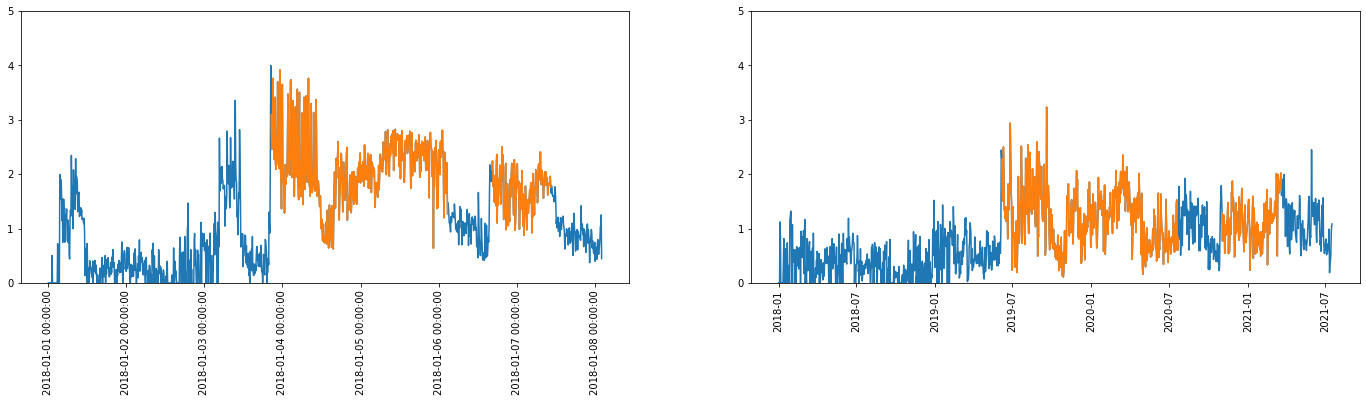

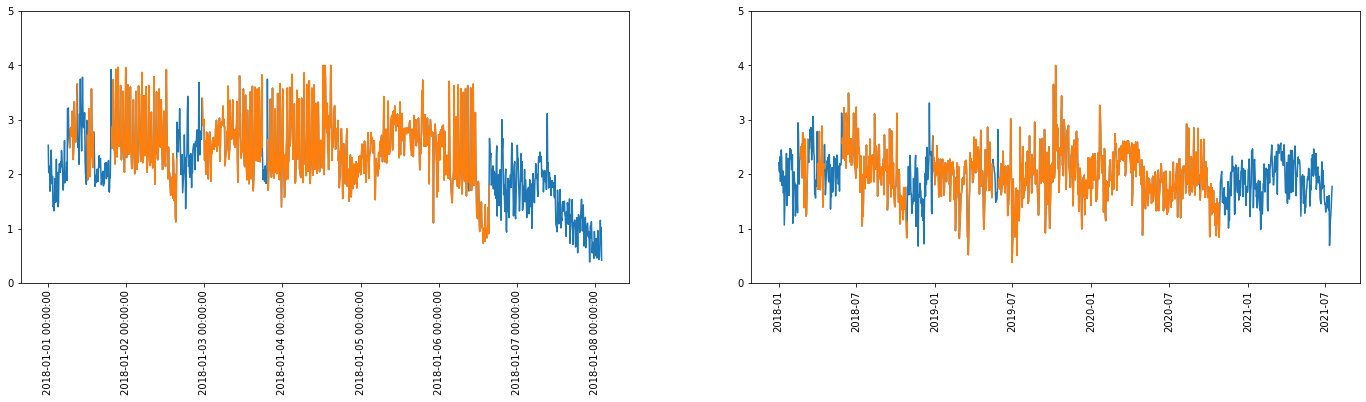

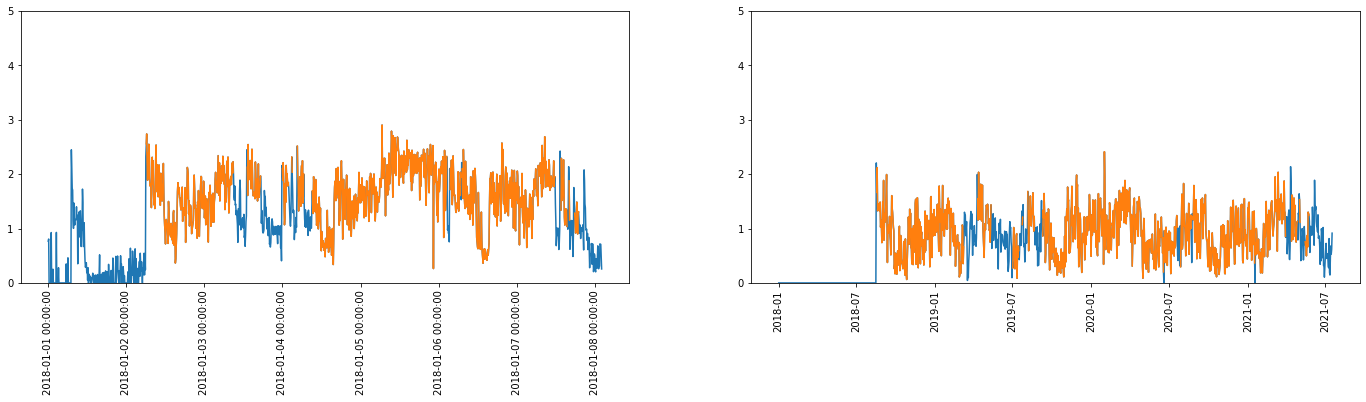

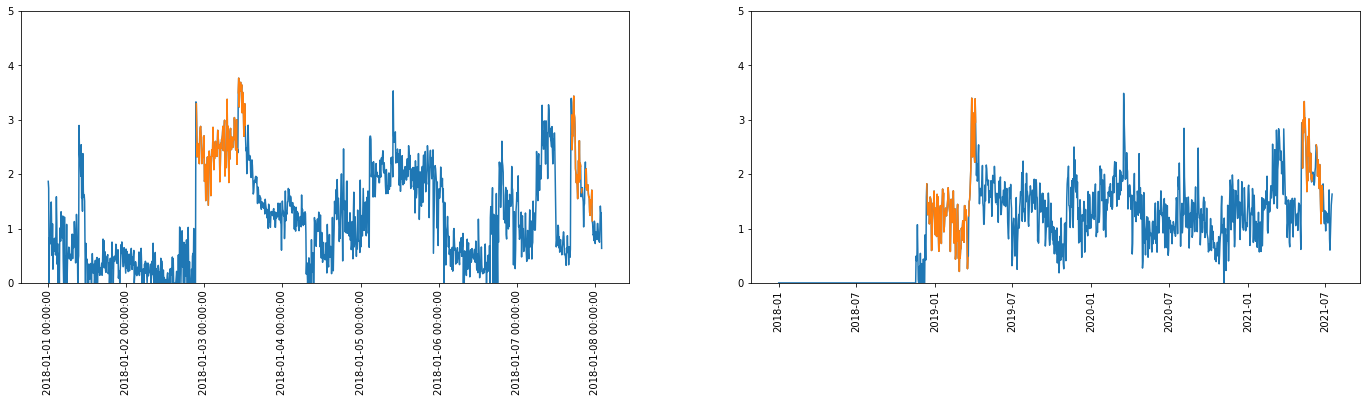

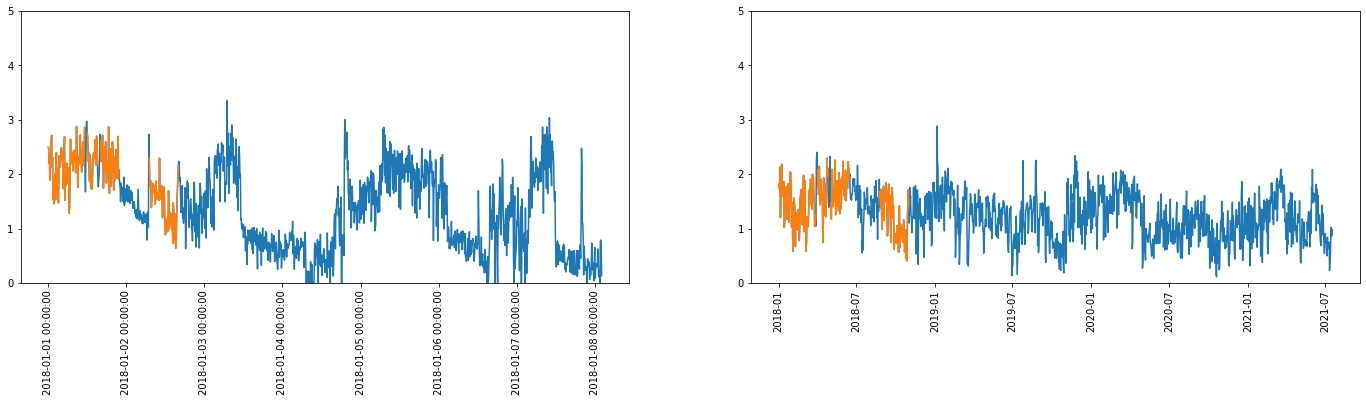

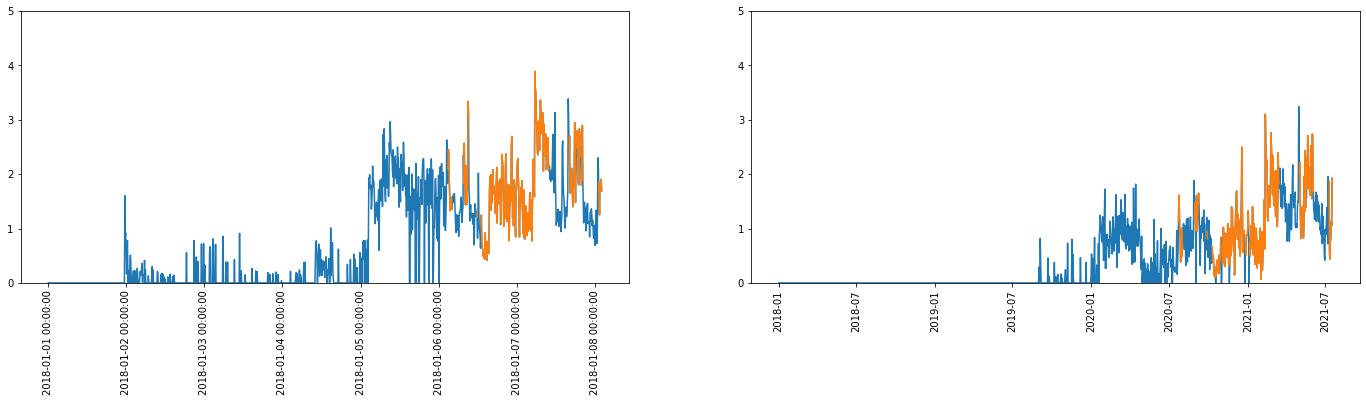

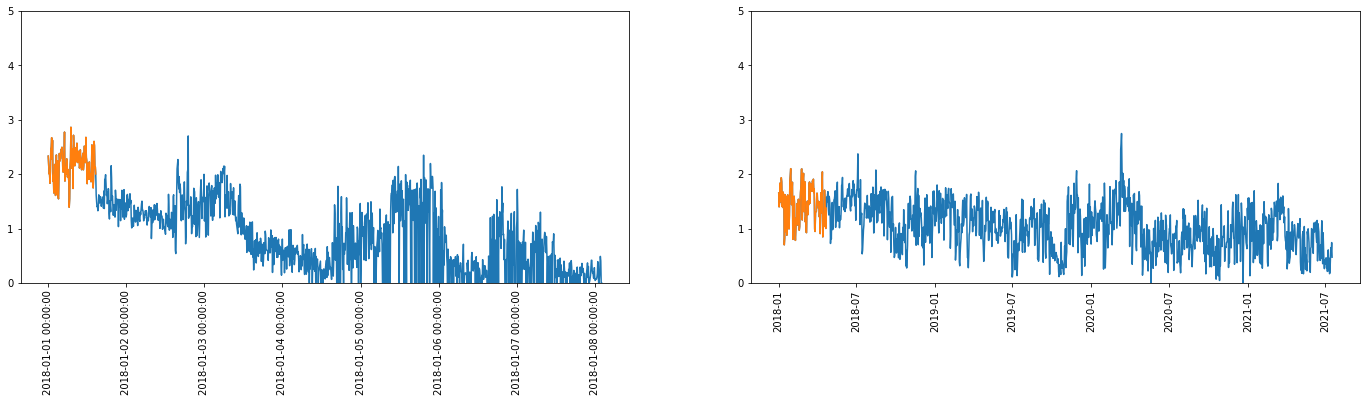

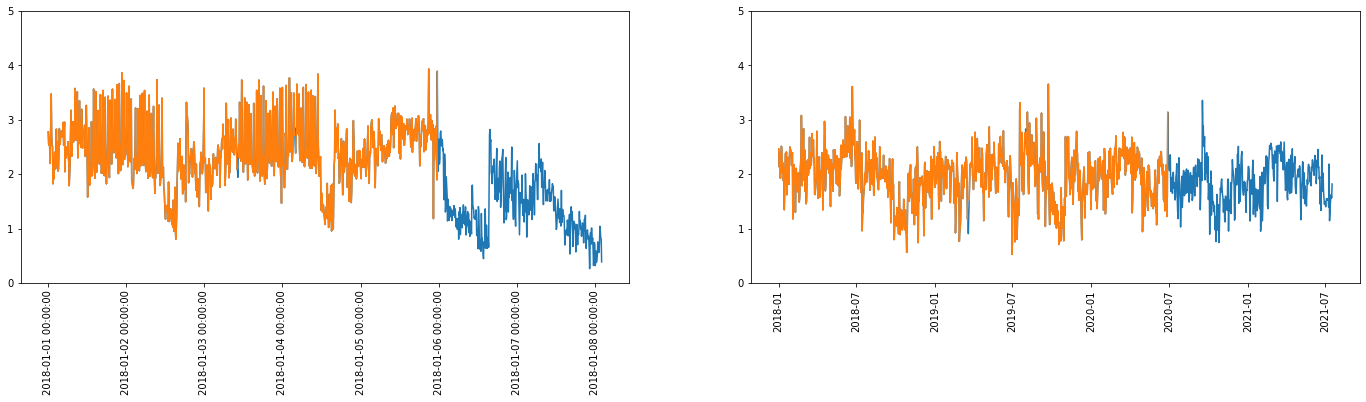

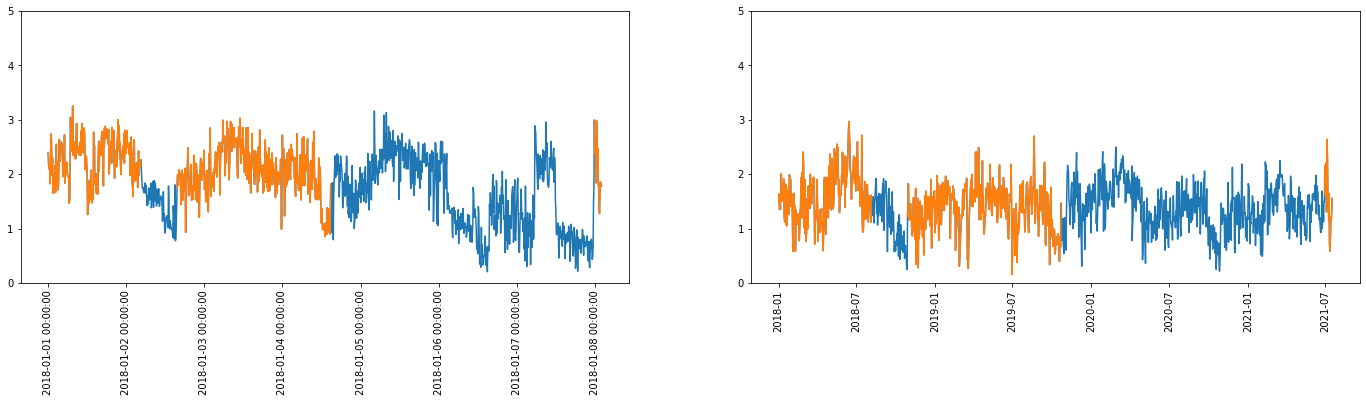

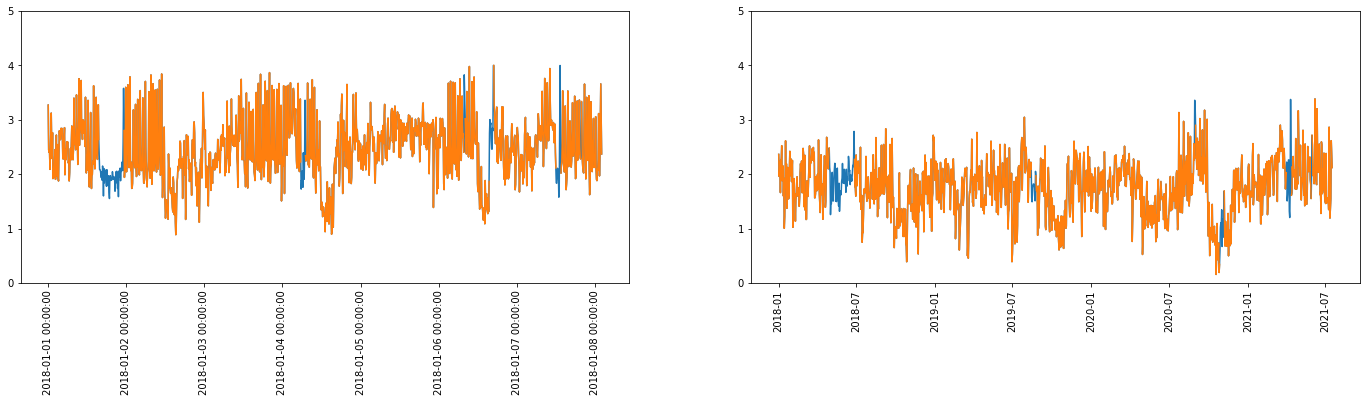

In [24]:
ll = list(set(train_nextDayPlayerEngagement['playerId']))
a4_dims = (24, 5)
#_10log100,['target2_10log100','target2_10log10']
#target_var = list(['target1','target3'])
target_var = list(['target2_10log100','target4_10log100'])
for i in range(10):
    player_df = train_nextDayPlayerEngagement[train_nextDayPlayerEngagement['playerId']==ll[100*i+4]]
    fig, ax = plt.subplots(1,len(target_var),figsize=a4_dims)
    for i in range(len(target_var)):
        kk = player_df[target_var[i]]
        gg = player_df[target_var[i]]*(player_df['isActive_player']) #*(player_df['Date_pre_DT'].dt.year == 2019)
        gg = gg.mask(gg == 0,np.nan)
        ax[i].set(ylim = (0,5))
        ax[i].plot(player_df['Date_pre_DT'],kk)
        ax[i].plot(player_df['Date_pre_DT'],gg)
        ax[0].set_xticklabels(player_df['Date_pre_DT'],rotation=90)
        for tick in ax[i].get_xticklabels():
            tick.set_rotation(90)
    plt.show

See quanter level reverse cum count

In [25]:
dd = pd.DataFrame()

#'in_season', 'date_hvGame', 'isActive_player', 'date_MajorGame', 'isActiveMajorGame_player'
#'teamId','statusCode'
TF_feature = 'statusCode'

#Logic_list = list([True,"All",False])
Logic_list = set(train_nextDayPlayerEngagement[TF_feature])

for logic in Logic_list:
    if logic == "All":
        df = train_nextDayPlayerEngagement
    else:
        df = train_nextDayPlayerEngagement[train_nextDayPlayerEngagement[TF_feature]==logic]
        
    for level_p in Level_gp:
        column_veiw = [str(level_p)+'_target1',str(level_p)+'_target3']
        dd[level_p] = (df[column_veiw].mean()).reset_index(drop=True)# * df[column_veiw].count()).reset_index(drop=True)
        #dd = pd.merge(dd,train_rosters[['gameDate_DT','playerId','statusCode']], left_on=['playerId','Date_pre_DT'], right_on=['playerId','gameDate_DT'] ,how = "left"))
    
    print(TF_feature,str(logic),df['playerId'].count())
    display(dd)
    if logic == True:
        Ture_fig = pd.concat([pd.DataFrame(),dd])
    elif logic == False:
        False_fig = pd.concat([pd.DataFrame(),dd])
#result_fig = Ture_fig-False_fig
#display(result_fig)

statusCode FME 72


,1,2,3,4,5,10,20,90,99
0,0.027778,0.027778,0.013889,0.013889,0.013889,0.013889,0.000000,0.0,0.0
1,0.236111,0.111111,0.083333,0.083333,0.069444,0.013889,0.013889,0.0,0.0


statusCode D7 564


,1,2,3,4,5,10,20,90,99
0,0.046099,0.021277,0.015957,0.014184,0.010638,0.005319,0.003546,0.0,0.0
1,0.122340,0.097518,0.067376,0.053191,0.049645,0.021277,0.010638,0.0,0.0


statusCode RM 194416


,1,2,3,4,5,10,20,90,99
0,0.007052,0.004454,0.003297,0.002572,0.002037,0.000998,0.000463,0.000031,0.000026
1,0.026474,0.018419,0.014001,0.011393,0.009511,0.004948,0.002135,0.000170,0.000108


statusCode SU 267


,1,2,3,4,5,10,20,90,99
0,0.067416,0.037453,0.033708,0.022472,0.014981,0.011236,0.003745,0.0,0.0
1,0.134831,0.093633,0.067416,0.052434,0.044944,0.014981,0.003745,0.0,0.0


statusCode RES 8


,1,2,3,4,5,10,20,90,99
0,0.375,0.375,0.375,0.375,0.375,0.125,0.125,0.0,0.0
1,0.375,0.375,0.375,0.375,0.375,0.250,0.125,0.0,0.0


statusCode D10 56011


,1,2,3,4,5,10,20,90,99
0,0.030512,0.017514,0.011980,0.009159,0.007159,0.003285,0.001196,0.000089,0.000054
1,0.141347,0.104604,0.082644,0.067023,0.056489,0.027655,0.011051,0.000536,0.000268


statusCode DEC 1


,1,2,3,4,5,10,20,90,99
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


statusCode D60 61348


,1,2,3,4,5,10,20,90,99
0,0.006341,0.003684,0.002494,0.001858,0.001630,0.000880,0.000408,0.000000,0.000000
1,0.031949,0.022723,0.017458,0.014149,0.011671,0.006406,0.003032,0.000163,0.000082


statusCode PL 287


,1,2,3,4,5,10,20,90,99
0,0.059233,0.041812,0.031359,0.031359,0.020906,0.013937,0.006969,0.0,0.0
1,0.282230,0.216028,0.160279,0.132404,0.125436,0.083624,0.048780,0.0,0.0


statusCode BRV 198


,1,2,3,4,5,10,20,90,99
0,0.020202,0.015152,0.015152,0.010101,0.005051,0.005051,0.005051,0.0,0.0
1,0.166667,0.116162,0.106061,0.090909,0.070707,0.025253,0.005051,0.0,0.0


statusCode NA 1138858


,1,2,3,4,5,10,20,90,99
0,0.010467,0.006933,0.005303,0.004283,0.003583,0.001994,0.001056,0.000194,0.000172
1,0.016383,0.012261,0.010086,0.008660,0.007607,0.004944,0.002888,0.000489,0.000330


statusCode A 1214904


,1,2,3,4,5,10,20,90,99
0,0.133235,0.090656,0.069473,0.056261,0.047166,0.025689,0.012493,0.001192,0.000931
1,0.101960,0.075713,0.061468,0.051903,0.044975,0.026903,0.014349,0.001578,0.000937


In [26]:
#------------------------------------------------------------Log--------------------------------------------------------------

dd = pd.DataFrame()

#'in_season', 'date_hvGame', 'isActive_player', 'date_MajorGame', 'isActiveMajorGame_player'
#'teamId','statusCode',
TF_feature = 'statusCode'

#Logic_list = list([True,"All",False])
Logic_list = set(train_nextDayPlayerEngagement[TF_feature])

for logic in Logic_list:
    if logic == "All":
        df = train_nextDayPlayerEngagement
    else:
        df = train_nextDayPlayerEngagement[train_nextDayPlayerEngagement[TF_feature]==logic]
        
    for level_p in Level_loggp:
        column_veiw = [str(level_p)+'_target1_10log100',str(level_p)+'_target2_10log100',str(level_p)+'_target3_10log100',str(level_p)+'_target4_10log100']
        #column_veiw = [str(level_p)+'_target1',str(level_p)+'_target3']
        dd[level_p] = (df[column_veiw].mean()).reset_index(drop=True)# * df[column_veiw].count()).reset_index(drop=True)
        #dd = pd.merge(dd,train_rosters[['gameDate_DT','playerId','statusCode']], left_on=['playerId','Date_pre_DT'], right_on=['playerId','gameDate_DT'] ,how = "left"))
    
    print(TF_feature,str(logic),df['playerId'].count())
    display(dd)
    Ture_fig = pd.DataFrame()
    False_fig= pd.DataFrame()
    if logic == True:
        Ture_fig = pd.concat([pd.DataFrame(),dd])
    elif logic == False:
        False_fig = pd.concat([pd.DataFrame(),dd])
result_fig = Ture_fig-False_fig
display(result_fig)

statusCode FME 72


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.180556,0.041667,0.027778,0.027778,0.013889,0.013889,0.013889
1,1.000000,0.888889,0.638889,0.416667,0.277778,0.194444,0.138889
2,0.486111,0.277778,0.236111,0.111111,0.083333,0.083333,0.083333
3,0.847222,0.500000,0.305556,0.208333,0.138889,0.125000,0.125000


statusCode D7 564


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.177305,0.065603,0.046099,0.021277,0.015957,0.015957,0.014184
1,0.985816,0.675532,0.414894,0.218085,0.085106,0.051418,0.040780
2,0.342199,0.159574,0.122340,0.097518,0.067376,0.058511,0.054965
3,0.891844,0.496454,0.313830,0.148936,0.076241,0.060284,0.047872


statusCode RM 194416


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.026634,0.010874,0.007052,0.004454,0.003297,0.002916,0.002649
1,0.853433,0.307367,0.182310,0.087200,0.045979,0.035234,0.028650
2,0.071064,0.035234,0.026474,0.018419,0.014001,0.012556,0.011686
3,0.580822,0.138101,0.053766,0.020132,0.011553,0.009454,0.008178


statusCode SU 267


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.205993,0.078652,0.067416,0.037453,0.033708,0.029963,0.026217
1,0.988764,0.913858,0.707865,0.449438,0.277154,0.232210,0.217228
2,0.367041,0.172285,0.134831,0.093633,0.067416,0.056180,0.052434
3,0.730337,0.445693,0.295880,0.213483,0.183521,0.153558,0.149813


statusCode RES 8


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.375,0.375,0.375,0.375,0.375,0.375,0.375
1,1.000,0.750,0.750,0.500,0.500,0.500,0.375
2,0.375,0.375,0.375,0.375,0.375,0.375,0.375
3,1.000,0.750,0.500,0.500,0.375,0.375,0.375


statusCode D10 56011


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.120637,0.048133,0.030512,0.017514,0.011980,0.010266,0.009284
1,0.966667,0.535680,0.296174,0.145918,0.091339,0.075592,0.066112
2,0.308672,0.177751,0.141347,0.104604,0.082644,0.074075,0.068201
3,0.864419,0.479424,0.294442,0.154987,0.101801,0.084948,0.074985


statusCode DEC 1


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0


statusCode D60 61348


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.029553,0.010432,0.006341,0.003684,0.002494,0.002184,0.001891
1,0.800434,0.261948,0.123199,0.052879,0.030596,0.024353,0.020718
2,0.097819,0.042675,0.031949,0.022723,0.017458,0.015534,0.014393
3,0.728695,0.318022,0.180674,0.090402,0.056090,0.046163,0.039952


statusCode PL 287


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.226481,0.097561,0.059233,0.041812,0.031359,0.031359,0.031359
1,1.000000,0.891986,0.662021,0.390244,0.282230,0.247387,0.226481
2,0.487805,0.334495,0.282230,0.216028,0.160279,0.142857,0.132404
3,0.958188,0.686411,0.508711,0.344948,0.243902,0.226481,0.209059


statusCode BRV 198


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.181818,0.050505,0.020202,0.015152,0.015152,0.010101,0.010101
1,0.994949,0.823232,0.585859,0.252525,0.166667,0.151515,0.141414
2,0.348485,0.207071,0.166667,0.116162,0.106061,0.095960,0.090909
3,0.934343,0.636364,0.338384,0.166667,0.126263,0.106061,0.106061


statusCode NA 1138858


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.029473,0.014781,0.010467,0.006933,0.005303,0.004749,0.004368
1,0.405545,0.210350,0.135757,0.074989,0.049382,0.041734,0.036750
2,0.037507,0.020978,0.016383,0.012261,0.010086,0.009318,0.008789
3,0.491878,0.195203,0.108741,0.055779,0.036534,0.030934,0.027458


statusCode A 1214904


,0.1,0.5,1.0,2.0,3.0,3.5,3.9
0,0.296944,0.180819,0.133235,0.090656,0.069473,0.062165,0.057357
1,0.968367,0.827377,0.676690,0.484331,0.368738,0.326235,0.297164
2,0.238661,0.132671,0.101960,0.075713,0.061468,0.056197,0.052699
3,0.821392,0.482425,0.317646,0.184600,0.126336,0.108029,0.096377


""


See the distrubite different

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


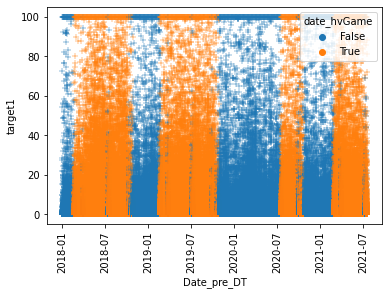

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


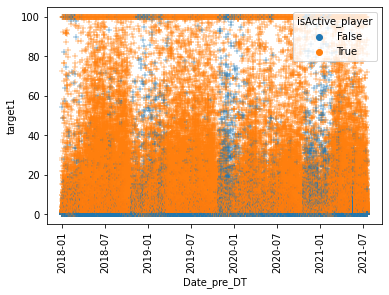

In [28]:
kk  = train_nextDayPlayerEngagement.groupby('Date_pre_DT').mean()
#for i in range(4):
for i in range(1):    
    sns.scatterplot(train_nextDayPlayerEngagement['Date_pre_DT'],train_nextDayPlayerEngagement['target'+str(i+1)],marker="+",hue = train_nextDayPlayerEngagement['date_hvGame'])
    plt.xticks(rotation=90)
    plt.show()
#for i in range(4):
for i in range(1):    
    sns.scatterplot(train_nextDayPlayerEngagement['Date_pre_DT'],train_nextDayPlayerEngagement['target'+str(i+1)],marker="+",hue = train_nextDayPlayerEngagement['isActive_player'])
    plt.xticks(rotation=90)
    plt.show()

Stat different from Active to non Active

In [ ]:
date_condition = (train_nextDayPlayerEngagement['date_hvGame'] == True)
Nactive = train_nextDayPlayerEngagement[date_condition & (train_nextDayPlayerEngagement['isActive_player'] == False)][['target1','target2','target3','target4']].describe()
is_active = train_nextDayPlayerEngagement[date_condition & (train_nextDayPlayerEngagement['isActive_player'] == True)][['target1','target2','target3','target4']].describe()
is_active - Nactive

Targets Stat review

In [29]:
#def Q_n(x,n):
#    return x.quantile(n/100)
def q90(x):
    return x.quantile(0.9)
def q10(x):
    return x.quantile(0.1)
def q75(x):
    return x.quantile(0.75)
def cum_q75(x):
    return x[x<x.quantile(0.75)].sum()
df2 = train_nextDayPlayerEngagement
#review_target_byplayer = df2[['playerId','target1_10log100','target2_10log100','target3_10log100','target4_10log100']].groupby('playerId').agg(['min',q10,'mean','median',q90,'max'])
review_target_byplayer = df2[['playerId','target1','target3','target2','target4']].groupby('playerId').agg(['min',q10,'mean','median',q75,q90,'max',cum_q75])
display(review_target_byplayer)

target1                                                    \
               min       q10      mean    median       q75       q90   
playerId                                                               
112526    0.000322  0.004737  0.900406  0.036089  0.174314  0.777233   
134181    0.000742  0.004226  1.697881  0.055257  0.524004  2.414023   
279571    0.000000  0.000000  0.009850  0.000000  0.000412  0.002528   
282332    0.000891  0.005226  3.312164  0.131618  1.042228  7.125700   
400085    0.002539  0.016866  1.779801  0.072013  0.273088  1.447116   
...            ...       ...       ...       ...       ...       ...   
681911    0.000000  0.000000  0.006452  0.000000  0.000000  0.000357   
683232    0.000000  0.000000  0.000631  0.000000  0.000000  0.000160   
683734    0.000000  0.000000  0.640488  0.000000  0.116466  1.033137   
685493    0.000000  0.000000  0.060293  0.000000  0.000560  0.005710   
685503    0.000000  0.000000  0.036658  0.000000  0.000000  0.001045   

                                   target3                                \
                 max     cum_q75       min       q10      mean    median   
playerId                                                                   
112526    100.000000   33.913999  0.002746  0.020263  2.118152  0.108433   
134181    100.000000   74.778560  0.005872  0.038263  2.501845  0.140967   
279571      2.089996    0.032049  0.000000  0.000000  0.045981  0.000000   
282332    100.000000  151.774295  0.006188  0.036831  4.618312  0.285185   
400085    100.000000   66.421653  0.015469  0.053240  3.068264  0.179221   
...              ...         ...       ...       ...       ...       ...   
681911      1.866614    0.000000  0.000000  0.000000  0.367179  0.000000   
683232      0.449478    0.000000  0.000000  0.000000  0.012390  0.000000   
683734    100.000000   10.224764  0.000000  0.000000  1.362387  0.000000   
685493     11.595944    0.034308  0.000000  0.000000  0.099076  0.000000   
685503     15.077294    0.000000  0.000000  0.000000  0.049141  0.000000   

                                                        target2            \
               q75        q90         max     cum_q75       min       q10   
playerId                                                                    
112526    0.374186   2.412422  100.000000   92.983197  0.056316  0.300326   
134181    0.590586   3.561027  100.000000  133.723867  0.022804  0.186257   
279571    0.001272   0.005833    6.829104    0.148455  0.000000  0.000000   
282332    1.995638  10.914452  100.000000  314.082046  0.027783  0.211821   
400085    0.521984   3.737287  100.000000  157.089335  0.120257  0.502011   
...            ...        ...         ...         ...       ...       ...   
681911    0.003456   0.037164  100.000000    0.208830  0.000000  0.000000   
683232    0.000000   0.000000    6.545095    0.000000  0.000000  0.000000   
683734    0.344883   2.093839   96.643715   33.321408  0.000000  0.000000   
685493    0.001664   0.016621   37.317411    0.099270  0.000000  0.000000   
685503    0.000000   0.001757    7.940695    0.000000  0.000000  0.000000   

                                                                            \
              mean    median       q75        q90         max      cum_q75   
playerId                                                                     
112526    4.679105  1.513561  4.702194  10.056123  100.000000  1342.612381   
134181    3.394928  0.936914  4.313520   9.608467   76.411290   951.454067   
279571    0.340168  0.069399  0.349281   0.806909   20.049566    71.553775   
282332    6.811926  3.046538  6.827885  13.224324  100.000000  2223.219012   
400085    6.719536  1.803266  5.478940  19.281049  100.000000  1585.768724   
...            ...       ...       ...        ...         ...          ...   
681911    0.616167  0.004361  0.284925   1.090924   78.081472    33.182437   
683232    0.226388  0.003971  0.167660   0.665144   15.866635    18.372371   


T2/4 > T1/3

2 ~= 4 1 ~= 3

To Prove the trend among Targets

Try to review distubion in tragets

In [ ]:
#confirm the trend asumption among targets, and stat
a4_dims = (30, 15)
fig, ax = plt.subplots(figsize=a4_dims)
Detect_A = 'target3'
Detect_B = 'target4'
Detect_stat = 'cum_q75'
reviewplot = pd.DataFrame()
reviewplot['diff'] = review_target_byplayer[Detect_A][Detect_stat] - review_target_byplayer[Detect_B][Detect_stat]
reviewplot[Detect_A] = review_target_byplayer[Detect_A][Detect_stat]
reviewplot[Detect_B] = review_target_byplayer[Detect_B][Detect_stat]
reviewplot = reviewplot.sort_values('diff')
sns.scatterplot(range(len(review_target_byplayer)),reviewplot[Detect_A],color = 'b')
sns.scatterplot(range(len(review_target_byplayer)),reviewplot[Detect_B],color = 'g')
sns.lineplot(range(len(review_target_byplayer)),reviewplot['diff'],color = 'r')
#sns.scatterplot(range(len(review_target_byplayer)),review_target_byplayer['target1']['median'],marker="_")
#sns.scatterplot(range(len(review_target_byplayer)),review_target_byplayer['target2']['median'],marker="_")
#sns.scatterplot(range(len(review_target_byplayer)),review_target_byplayer['target3']['median'])#,marker="-")
#sns.scatterplot(range(len(review_target_byplayer)),review_target_byplayer['target4']['median'])#,marker="_")
plt.xticks(rotation=90)
plt.show()

In [ ]:
a4_dims = (30, 15)
fig, ax = plt.subplots(figsize=a4_dims)
Detect_var = 'target4'
kk = train_nextDayPlayerEngagement[train_nextDayPlayerEngagement['isActive_player']==True].sort_values(Detect_var, ascending= False)
sns.scatterplot(range(len(kk)),kk[Detect_var])
#sns.scatterplot(range(len(review_target_byplayer)),review_target_byplayer['target1']['median'],marker="_")
#sns.scatterplot(range(len(review_target_byplayer)),review_target_byplayer['target2']['median'],marker="_")
#sns.scatterplot(range(len(review_target_byplayer)),review_target_byplayer['target3']['median'])#,marker="-")
#sns.scatterplot(range(len(review_target_byplayer)),review_target_byplayer['target4']['median'])#,marker="_")
ax.set(ylim = (0,100))
plt.xticks(rotation=90)
plt.show()

take sample to see players ACF/PACF

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


<BarContainer object of 41 artists>

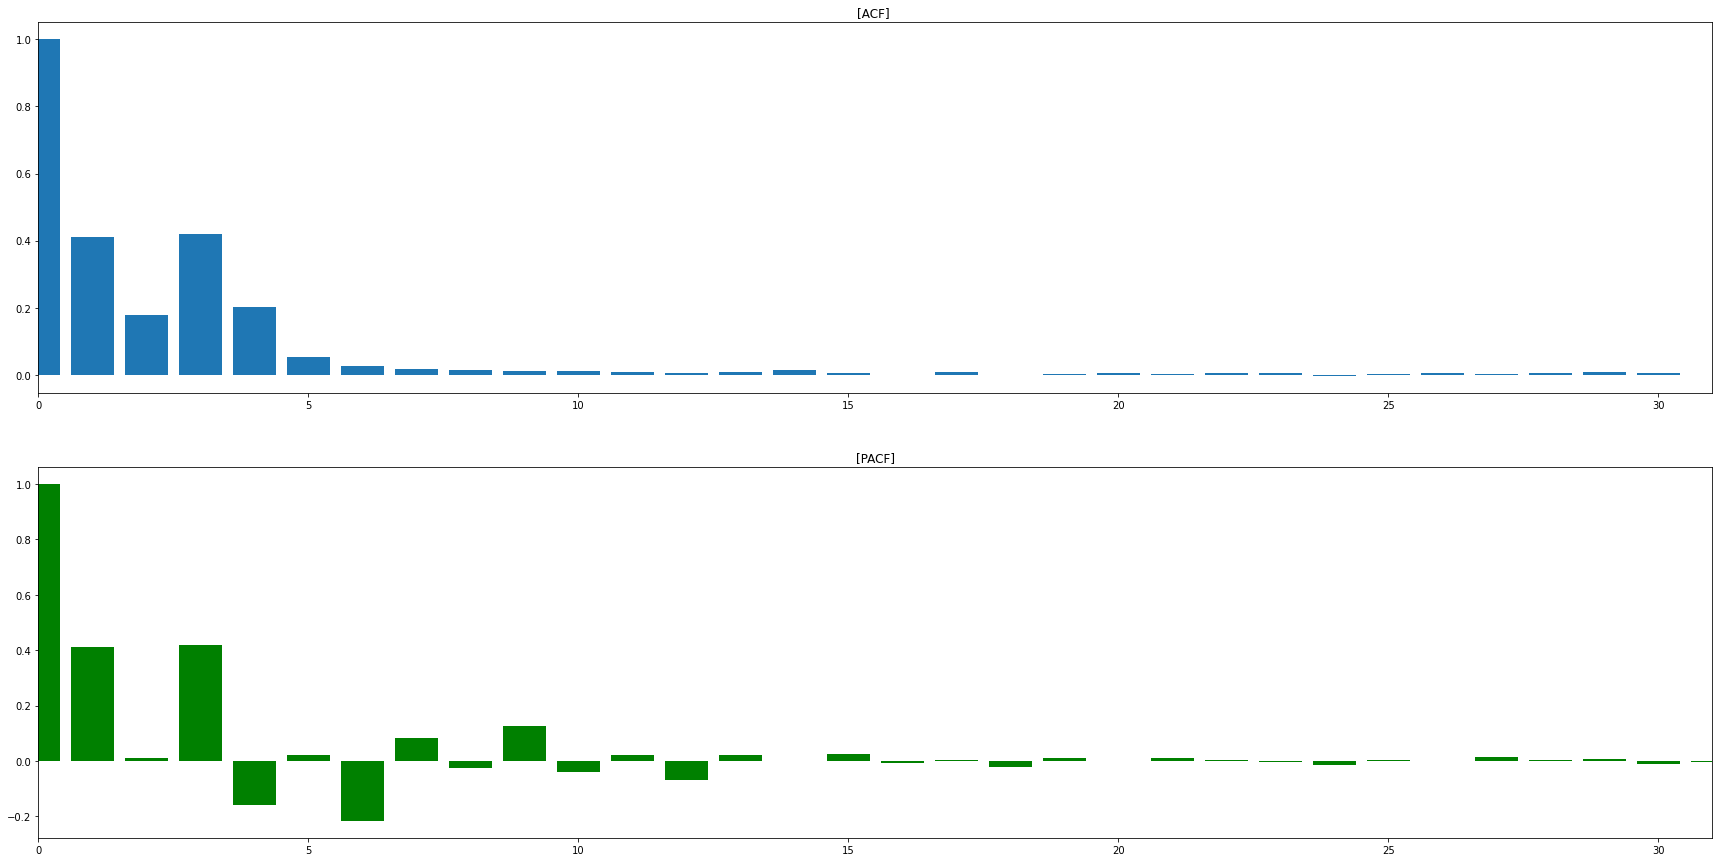

In [30]:
sample_player = train_nextDayPlayerEngagement.sample()
#target_player= sample_player.loc('playerId',0)
selected_logic = (train_nextDayPlayerEngagement['playerId'] == int(sample_player['playerId'])) & (train_nextDayPlayerEngagement['in_season'] == True) & (train_nextDayPlayerEngagement['Date_pre_DT'].dt.year == 2019)
df = train_nextDayPlayerEngagement[selected_logic]['target2']

ACF_Trend = acf(df)
PACF_Trend = pacf(df,40)[:]

a4_dims = (30, 15)
fig, ax = plt.subplots(2,figsize=a4_dims)
ax[0].set_title('[ACF] ')
ax[0].bar(range(ACF_Trend.size),ACF_Trend)
ax[0].set(xlim = (0,31))
#ax[0].bar(range(PACF_Trend.size),PACF_Trend,color = 'green')
ax[1].set_title('[PACF]')
ax[1].set(xlim = (0,31))
ax[1].bar(range(PACF_Trend.size),PACF_Trend,color = 'green')

In [31]:
#aim in AR(1), MR(1)

playerId_list = set(train_nextDayPlayerEngagement['playerId'])
ACF_table = pd.DataFrame(index=playerId_list)#,columns=[['ACF','PACF']])
#n = 0
for player_th in playerId_list:
    selected_logic = (train_nextDayPlayerEngagement['playerId'] == int(player_th)) & (train_nextDayPlayerEngagement['in_season'] == True) & (train_nextDayPlayerEngagement['Date_pre_DT'].dt.year == 2019)
    for i in range(4):
        df = train_nextDayPlayerEngagement[selected_logic]['target'+str(i+1)]
        if sum(df) ==0:
            continue
        ACF_table.loc[int(player_th),'ACF_target'+str(i+1)] = acf(df,nlags=2,fft=True)[1]
        ACF_table.loc[int(player_th),'PACF_target'+str(i+1)] = pacf(df,nlags=2)[1]
        
        df = train_nextDayPlayerEngagement[selected_logic]['target'+str(i+1)+'_10log100']
        if sum(df) ==0:
            continue
        ACF_table.loc[int(player_th),'ACF_target'+str(i+1)+'_10log100'] = acf(df,nlags=2,fft=True)[1]
        ACF_table.loc[int(player_th),'PACF_target'+str(i+1)+'_10log100'] = pacf(df,nlags=2)[1]

In [32]:
#ACF_table.to_csv('/kaggle/working/ACF_table.csv')

In [33]:
display(ACF_table[['ACF_target1','PACF_target1','ACF_target3','PACF_target3',]].describe())
display(ACF_table[['ACF_target2_10log100','PACF_target2_10log100','ACF_target4_10log100','PACF_target4_10log100',]].describe())

,ACF_target1,PACF_target1,ACF_target3,PACF_target3
count,1860.000000,1860.000000,1818.000000,1818.000000
mean,0.332262,0.333759,0.324447,0.325908
std,0.192010,0.192875,0.167570,0.168325
min,-0.098040,-0.098481,-0.081528,-0.081895
25%,0.192174,0.193040,0.197724,0.198614
50%,0.345807,0.347365,0.317216,0.318645
75%,0.473399,0.475531,0.445480,0.447486
max,0.858752,0.862620,0.806116,0.809747


,ACF_target2_10log100,PACF_target2_10log100,ACF_target4_10log100,PACF_target4_10log100
count,2060.000000,2060.000000,1938.000000,1938.000000
mean,0.671201,0.674224,0.645036,0.647942
std,0.171475,0.172248,0.127013,0.127585
min,-0.082486,-0.082858,-0.032176,-0.032321
25%,0.590307,0.592966,0.602824,0.605539
50%,0.712210,0.715418,0.662611,0.665596
75%,0.791938,0.795505,0.711899,0.715105
max,0.950450,0.954731,0.956804,0.961114


In [34]:
display(ACF_table[['ACF_target1','PACF_target1','ACF_target3','PACF_target3',]].describe())
display(ACF_table[['ACF_target2','PACF_target2','ACF_target4','PACF_target4',]].describe())
display(ACF_table[['ACF_target1_10log100','PACF_target1_10log100','ACF_target3_10log100','PACF_target3_10log100',]].describe())
display(ACF_table[['ACF_target2_10log100','PACF_target2_10log100','ACF_target4_10log100','PACF_target4_10log100',]].describe())

,ACF_target1,PACF_target1,ACF_target3,PACF_target3
count,1860.000000,1860.000000,1818.000000,1818.000000
mean,0.332262,0.333759,0.324447,0.325908
std,0.192010,0.192875,0.167570,0.168325
min,-0.098040,-0.098481,-0.081528,-0.081895
25%,0.192174,0.193040,0.197724,0.198614
50%,0.345807,0.347365,0.317216,0.318645
75%,0.473399,0.475531,0.445480,0.447486
max,0.858752,0.862620,0.806116,0.809747


,ACF_target2,PACF_target2,ACF_target4,PACF_target4
count,2060.000000,2060.000000,1938.000000,1938.000000
mean,0.427181,0.429106,0.415741,0.417613
std,0.215937,0.216910,0.156067,0.156770
min,-0.079715,-0.080074,-0.031552,-0.031694
25%,0.256525,0.257680,0.309067,0.310459
50%,0.459539,0.461609,0.428899,0.430831
75%,0.595647,0.598330,0.531465,0.533859
max,0.877733,0.881687,0.867108,0.871014


,ACF_target1_10log100,PACF_target1_10log100,ACF_target3_10log100,PACF_target3_10log100
count,1860.000000,1860.000000,1818.000000,1818.000000
mean,0.601919,0.604630,0.639398,0.642278
std,0.245945,0.247053,0.200965,0.201871
min,-0.098677,-0.099121,-0.082237,-0.082607
25%,0.566082,0.568632,0.609372,0.612117
50%,0.681580,0.684650,0.701445,0.704604
75%,0.758178,0.761593,0.760375,0.763801
max,0.922158,0.926312,0.943224,0.947473


,ACF_target2_10log100,PACF_target2_10log100,ACF_target4_10log100,PACF_target4_10log100
count,2060.000000,2060.000000,1938.000000,1938.000000
mean,0.671201,0.674224,0.645036,0.647942
std,0.171475,0.172248,0.127013,0.127585
min,-0.082486,-0.082858,-0.032176,-0.032321
25%,0.590307,0.592966,0.602824,0.605539
50%,0.712210,0.715418,0.662611,0.665596
75%,0.791938,0.795505,0.711899,0.715105
max,0.950450,0.954731,0.956804,0.961114


In [35]:
ACF_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 663554 to 663538
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ACF_target1            1860 non-null   float64
 1   PACF_target1           1860 non-null   float64
 2   ACF_target1_10log100   1860 non-null   float64
 3   PACF_target1_10log100  1860 non-null   float64
 4   ACF_target2            2060 non-null   float64
 5   PACF_target2           2060 non-null   float64
 6   ACF_target2_10log100   2060 non-null   float64
 7   PACF_target2_10log100  2060 non-null   float64
 8   ACF_target3            1818 non-null   float64
 9   PACF_target3           1818 non-null   float64
 10  ACF_target3_10log100   1818 non-null   float64
 11  PACF_target3_10log100  1818 non-null   float64
 12  ACF_target4            1938 non-null   float64
 13  PACF_target4           1938 non-null   float64
 14  ACF_target4_10log100   1938 non-null   float64
 1

<BarContainer object of 41 artists>

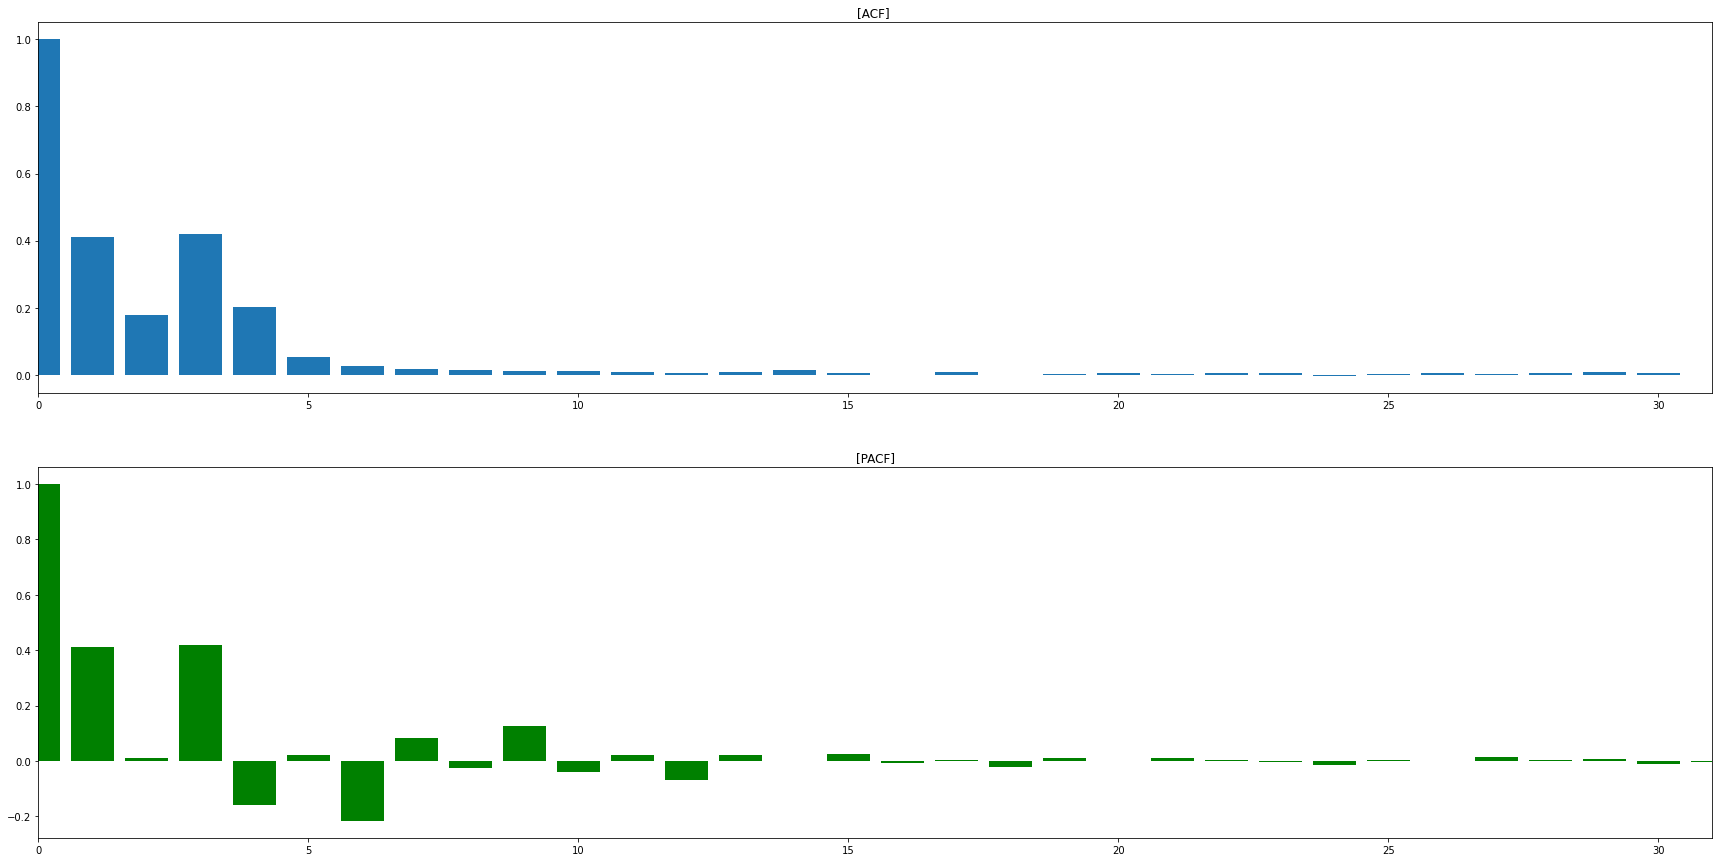

In [36]:

a4_dims = (30, 15)
fig, ax = plt.subplots(2,figsize=a4_dims)
ax[0].set_title('[ACF] ')
ax[0].bar(range(ACF_Trend.size),ACF_Trend)
ax[0].set(xlim = (0,31))
#ax[0].bar(range(PACF_Trend.size),PACF_Trend,color = 'green')
ax[1].set_title('[PACF]')
ax[1].set(xlim = (0,31))
ax[1].bar(range(PACF_Trend.size),PACF_Trend,color = 'green')

/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


,Unnamed: 0,index,playerId,gameDate,teamId,statusCode,status,gameDate_DT
0,0,0,400121,2018-01-01,116,A,Active,2018-01-01
1,1,1,408045,2018-01-01,142,A,Active,2018-01-01
2,2,2,425492,2018-01-01,120,A,Active,2018-01-01
3,3,3,429664,2018-01-01,136,A,Active,2018-01-01
4,4,4,431151,2018-01-01,121,A,Active,2018-01-01
...,...,...,...,...,...,...,...,...
1591359,1591359,1348,676646,2021-07-17,119,RM,Reassigned to Minors,2021-07-17
1591360,1591360,1349,676831,2021-07-17,138,RM,Reassigned to Minors,2021-07-17
1591361,1591361,1350,676879,2021-07-17,158,RM,Reassigned to Minors,2021-07-17
1591362,1591362,1351,677551,2021-07-17,139,A,Active,2021-07-17


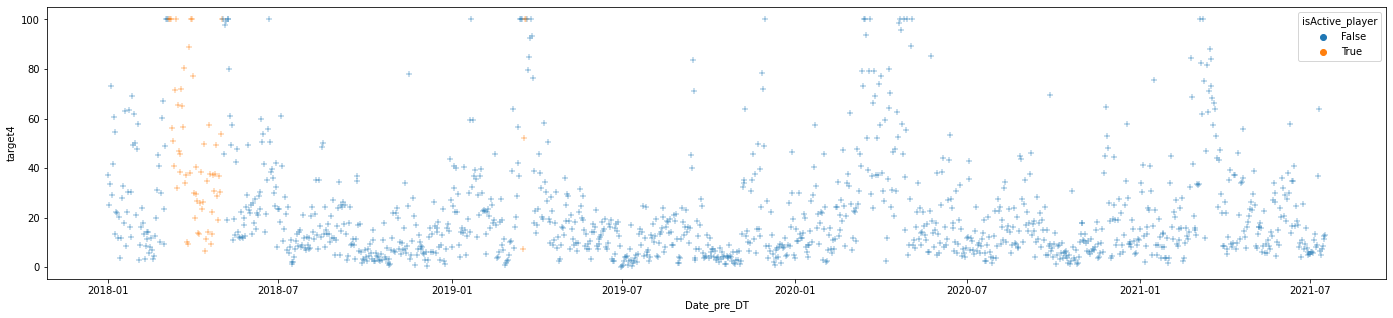

In [39]:
#review lenged
a4_dims = (24, 5)
fig, ax = plt.subplots(1,1,figsize=a4_dims)
sns.scatterplot(data=train_nextDayPlayerEngagement[train_nextDayPlayerEngagement['playerId'] == 400085], x='Date_pre_DT', y='target4', marker="+",hue='isActive_player')

example_sample_submission[['date','playerId']] = example_sample_submission['date_playerId'].str.split('_',expand=True)
example_sample_submission
train_rosters

In [40]:
train_nextDayPlayerEngagement[train_nextDayPlayerEngagement['T1_abnormal']==True]['target1'].describe()

count    321681.000000
mean          3.969241
std          11.396088
min           0.000048
25%           0.003036
50%           0.095641
75%           2.401658
max         100.000000
Name: target1, dtype: float64